In [1]:
from statsforecast import StatsForecast
from statsforecast.models import (AutoARIMA, AutoETS, AutoTheta, AutoCES)
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import yfinance as yf
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsforecast/core.py:27: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
# Descargar datos
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'NVDA', 'META', 'IBM', 'BTC-USD']
Y_df = yf.download(tickers, start='2000-01-01', interval='1d')['Adj Close']

# Resetear el índice y transformar el DataFrame
Y_df = Y_df.reset_index().melt(id_vars='Date', var_name='unique_id', value_name='y')
Y_df = Y_df.rename(columns={'Date': 'ds'})
Y_df = Y_df[['unique_id', 'ds', 'y']]
Y_df = Y_df.dropna(subset=['y']).reset_index(drop=True)

[*********************100%%**********************]  8 of 8 completed


In [3]:
# Split data into training and testing sets
Y_train_df = Y_df[Y_df.ds <= '2023-01-01'] # Train set
Y_test_df = Y_df[Y_df.ds > '2023-01-01']   # Test set

In [4]:
season_length = 7 # Define season length as 12 months for monthly data

# Define a list of models for forecasting
models = [
    AutoARIMA(season_length=season_length), # ARIMA model with automatic order selection and seasonal component
    AutoETS(season_length=season_length), # ETS model with automatic error, trend, and seasonal component
    AutoTheta(season_length=season_length), # Theta model with automatic seasonality detection
    AutoCES(season_length=season_length), # CES model with automatic seasonality detection
    
]

# Instantiate StatsForecast class with models, data frequency ('M' for monthly),
# and parallel computation on all CPU cores (n_jobs=-1)
sf = StatsForecast(
    models=models, # models for forecasting
    freq='D',  # frequency of the data
    n_jobs=-1  # number of jobs to run in parallel, -1 means using all processors
)

sf.fit(df=Y_df)

StatsForecast(models=[AutoARIMA,AutoETS,AutoTheta,CES])

In [5]:
# Generate forecasts for the specified horizon using the sf object
horizon = 180
Y_hat_df = sf.forecast(df=Y_train_df, h=horizon) # forecast data
Y_hat_df.head(5)

,ds,AutoARIMA,AutoETS,AutoTheta,CES
unique_id,,,,,
AAPL,2022-12-31,128.602234,128.900558,128.937088,129.288666
AAPL,2023-01-01,128.248306,128.942719,128.858902,129.300751
AAPL,2023-01-02,128.364594,128.984879,128.852264,128.845444
AAPL,2023-01-03,128.436203,129.027039,128.625259,128.859116
AAPL,2023-01-04,128.375214,129.069199,128.727859,128.911179


In [6]:
Y_hat_df = Y_hat_df.reset_index()

def symmetric_mean_absolute_percentage_error(y_true, y_pred):
    return 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

def evaluate_forecast(y_true, y_pred):
    results = pd.DataFrame({
        'mae': [mean_absolute_error(y_true, y_pred)],
        'mse': [mean_squared_error(y_true, y_pred)],
        'mape': [mean_absolute_percentage_error(y_true, y_pred)],
        'rmse': [np.sqrt(mean_squared_error(y_true, y_pred))],
        'smape:': [symmetric_mean_absolute_percentage_error(y_true, y_pred)],
    })
    return results

# Evaluar múltiples modelos para múltiples tickers
evaluation_results_all_models = {}
models_to_evaluate = ['AutoARIMA', 'AutoETS', 'AutoTheta', 'CES']

for ticker in tickers:
    evaluation_results_all_models[ticker] = {}
    Y_test_true = Y_test_df[Y_test_df['unique_id'] == ticker]['y'].values[:horizon]
    for model in models_to_evaluate:
        Y_test_pred = Y_hat_df.loc[Y_hat_df['unique_id'] == ticker, model].values[:horizon]
        evaluation_results_all_models[ticker][model] = evaluate_forecast(Y_test_true, Y_test_pred)

# Imprimir resultados de evaluación para todos los modelos y tickers
for ticker, models_results in evaluation_results_all_models.items():
    print(f"Results for {ticker}:")
    for model, results in models_results.items():
        print(f"Model: {model}")
        print(results)
        print()

Results for AAPL:
Model: AutoARIMA
        mae          mse      mape       rmse     smape:
0  39.46153  1868.131491  0.226653  43.221887  26.080512

Model: AutoETS
         mae          mse      mape      rmse     smape:
0  34.802072  1455.816253  0.199872  38.15516  22.596625

Model: AutoTheta
         mae          mse      mape       rmse     smape:
0  36.927183  1641.502371  0.212002  40.515458  24.167545

Model: CES
         mae          mse      mape       rmse     smape:
0  35.353563  1503.436331  0.203011  38.774171  23.001447

Results for MSFT:
Model: AutoARIMA
         mae          mse      mape       rmse     smape:
0  54.423021  3962.735809  0.172518  62.950265  19.390895

Model: AutoETS
        mae          mse      mape       rmse     smape:
0  60.60639  4904.662599  0.192127  70.033296  21.904838

Model: AutoTheta
         mae         mse      mape       rmse     smape:
0  57.575894  4434.86687  0.182485  66.594796  20.662646

Model: CES
         mae          mse     map

In [7]:
cv_df = sf.cross_validation(df=Y_train_df, h=180, n_windows=3, step_size=180, level=[99])
cv_df.head(5)

,ds,cutoff,y,AutoARIMA,AutoARIMA-lo-99,AutoARIMA-hi-99,AutoETS,AutoETS-lo-99,AutoETS-hi-99,AutoTheta,AutoTheta-lo-99,AutoTheta-hi-99,CES,CES-lo-99,CES-hi-99
unique_id,,,,,,,,,,,,,,,
AAPL,2020-11-09,2020-11-06,114.001030,119.325455,117.402290,121.248611,116.389320,108.702820,124.075821,116.412979,115.049110,117.804596,116.358063,114.204132,118.578949
AAPL,2020-11-10,2020-11-06,113.658020,120.723862,117.391708,124.056015,116.452538,105.719856,127.185211,116.447601,114.483818,118.515678,116.849159,114.702141,119.113579
AAPL,2020-11-11,2020-11-06,117.107849,122.195229,116.851608,127.538849,116.515747,103.420502,129.610992,116.321983,114.019470,118.643127,116.494308,114.344124,118.754959
AAPL,2020-11-12,2020-11-06,116.833420,123.943573,116.453445,131.433701,116.578957,101.480347,131.677582,116.353149,113.481842,119.350723,116.936012,114.720345,119.146301
AAPL,2020-11-13,2020-11-06,116.882423,125.870674,115.923820,135.817535,116.642174,99.770935,133.513412,116.127342,113.011826,118.891068,116.999825,114.815170,119.237305


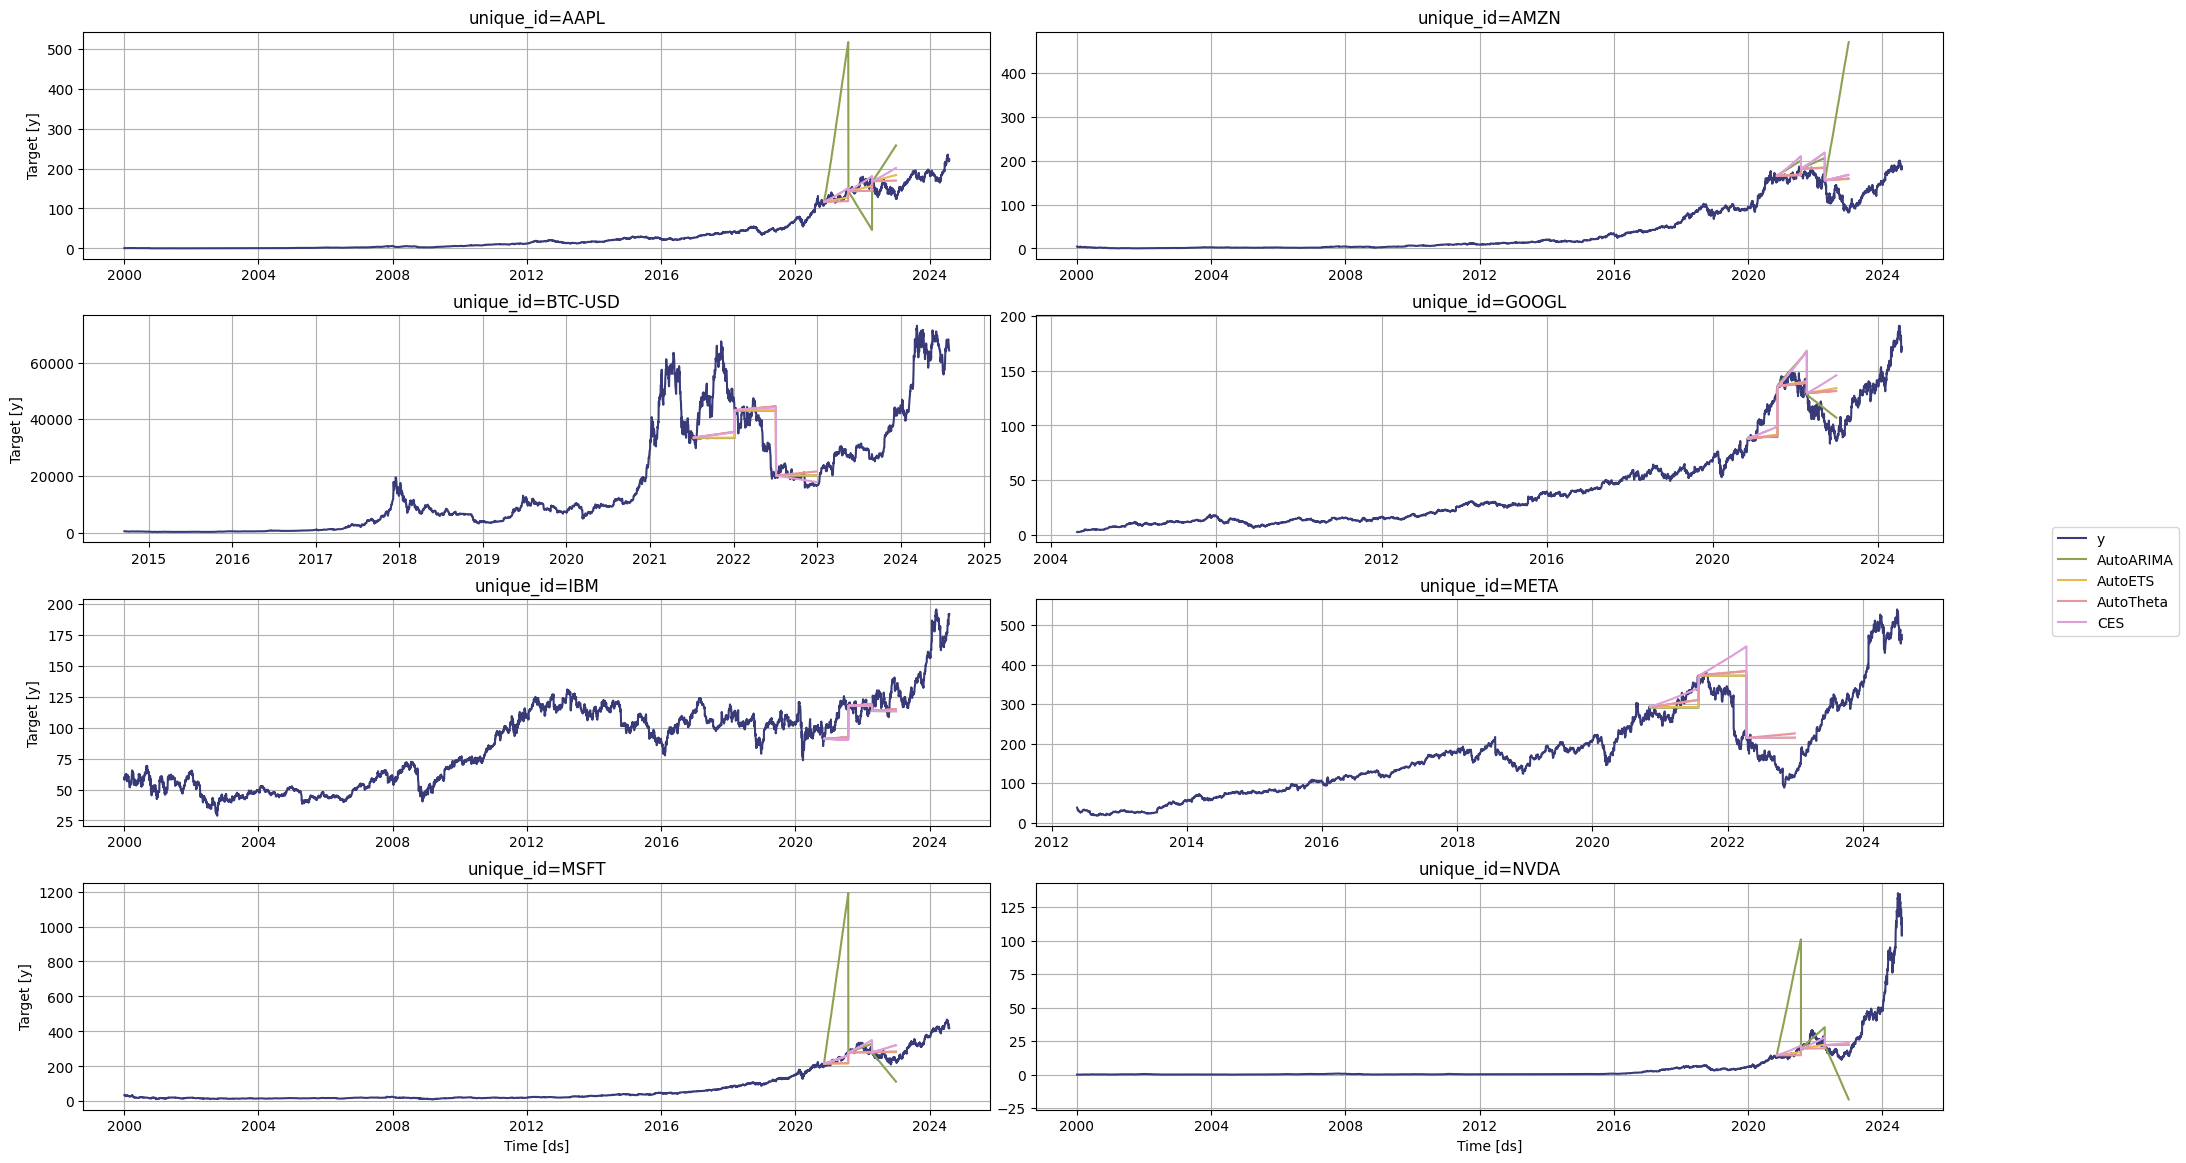

In [8]:
StatsForecast.plot(Y_df, cv_df.drop(['cutoff', 'y'], axis=1))